In [255]:
from tensorflow import keras
from keras.layers import LSTM, Activation, Dropout, Dense, Flatten, Reshape, Conv1D, AveragePooling1D, MaxPooling1D, GRU, CuDNNGRU, ReLU, SimpleRNN
import numpy as np, pandas as pd
from keras.utils.vis_utils import plot_model

# Obtain Dataset

Change api_key to swap from Bitcoin to Ethereum

Change limit in api_key to = number of days/hours - 1

For example, for 1 year limit=364

In [256]:
import json as js
import requests as req

#Store dataset with Pandas from cryptocompare historical price data API
api_key='?fsym=BTC&tsym=USD&limit=364' #for Bitcoin
#api_key='?fsym=ETH&tsym=USD&limit=364' #for Ethereum
url='https://min-api.cryptocompare.com/data/histoday'
path=url+api_key
historical_data = pd.DataFrame(js.loads(req.get(path).content)['Data'])
historical_data = historical_data.set_index('time')
historical_data.index = pd.to_datetime(historical_data.index, unit='s')
targ_column = 'close'

#drop unnecessary columns
historical_data.drop(['conversionType','conversionSymbol'], axis=1, inplace=True)

#check dataset first 5 items and number of items
print(historical_data.head(5))
print(len(historical_data))

                high       low      open  volumefrom      volumeto     close
time                                                                        
2021-09-09  47335.29  45572.30  46073.45    32273.70  1.499767e+09  46392.85
2021-09-10  47026.67  44198.27  46392.85    35701.24  1.631277e+09  44853.10
2021-09-11  45987.63  44741.98  44853.10    14599.26  6.622981e+08  45166.12
2021-09-12  46403.50  44765.82  45166.12    16366.41  7.471813e+08  46049.72
2021-09-13  46821.84  43511.30  46049.72    42623.67  1.909473e+09  44958.56
365


# Initialise Parameters

In [257]:
np.random.seed(50)
length_of_seq = 5
valsize = 0.25
testsize = 0.25
normalise = True
shuffle = True
nn_neurons = 150
batch = 256
runs = 20
loss_function = 'mean_squared_error'
dropout = 0.4
optimizer_function = 'NAdam'
activation_function='ReLU'

# Data Normalisation

In [258]:
def normalise_zero(price_data):
    #normalise dataset against first item
    price_data = price_data / price_data.iloc[0] - 1
    return price_data

def normalise_price_range(price_data):
    #normalise minimum to 0 and divide by range
    max, min = price_data.max(), price_data.min()
    price_range = (max - min)
    price_data = (price_data - min) / price_range
    return price_data

def y_normalise(trn, val, tst, trndata, valdata, tdata):
    trn = trn / trndata[targ_column][:-length_of_seq].values - 1
    val = val / valdata[targ_column][:-length_of_seq].values - 1
    tst = tst / tdata[targ_column][:-length_of_seq].values - 1
    return trn, val, tst

# Data Pre-processing

In [259]:
#Split data into training, validation and testing
def datasetsplit(historical_data, valsize, testsize):
    valsplit = int(len(historical_data)*valsize)
    testsplit = int(len(historical_data)*testsize)
    train_data = historical_data.iloc[:len(historical_data)-valsplit-testsplit]
    valid_data = historical_data.iloc[len(historical_data)-testsplit-valsplit:]
    test_data = historical_data.iloc[len(historical_data)-testsplit:]
    return train_data, valid_data, test_data

def get_sequence(data, length_of_seq, normalise=True):
    seq_window = []
    for x in range(len(data) - length_of_seq):
        placeholder = data[x: (x + length_of_seq)].copy()
        if normalise:
            placeholder = normalise_price_range(normalise_zero(placeholder))
        seq_window.append(placeholder.values)
    npseq=np.array(seq_window)
    return npseq

def data_processing(data, targ_column, length_of_seq=length_of_seq, normalise=normalise, valsize=valsize, testsize=testsize):
    train_data, valid_data, test_data = datasetsplit(data, valsize=valsize, testsize=testsize)
    X_train = get_sequence(train_data, length_of_seq, normalise)
    X_val = get_sequence(valid_data, length_of_seq, normalise)
    X_test = get_sequence(test_data, length_of_seq, normalise)
    y_train = train_data[targ_column][length_of_seq:]
    y_train = y_train.values
    y_val = valid_data[targ_column][length_of_seq:]
    y_val = y_val.values
    y_test = test_data[targ_column][length_of_seq:]
    y_test = y_test.values
    if normalise:
      y_train, y_val, y_test = y_normalise(y_train, y_val, y_test, train_data, valid_data, test_data)

    return train_data, valid_data, test_data, X_train, X_val, X_test, y_train, y_val, y_test

# Plotting functions

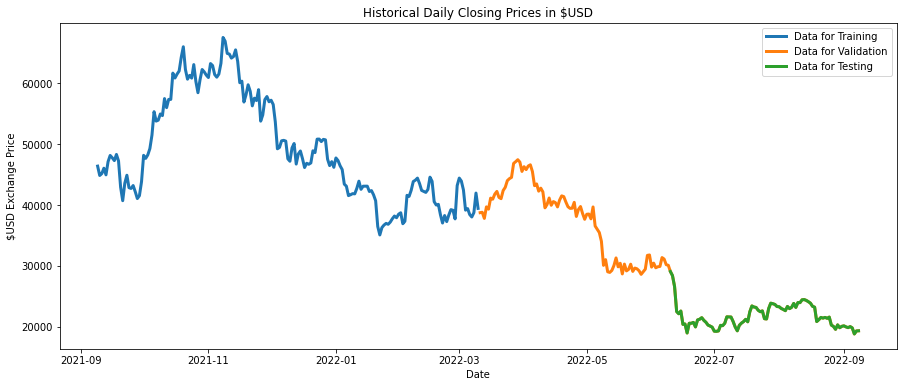

In [260]:
import matplotlib.pyplot as plt

#plot training, validation and testing datasets over time
def plothist(training, validation, testing, label1, label2, label3, width=3):
    figure, ax = plt.subplots(1, figsize=(15, 6))
    plot = ax.plot
    ax.set_title('Historical Daily Closing Prices in $USD')
    plot(training, label=label1, lw=width)
    plot(validation, label=label2, lw=width)
    plot(testing, label=label3, lw=width)
    ax.set_xlabel('Date')
    ax.set_ylabel('$USD Exchange Price')
    ax.legend()

train_data, valid_data, test_data = datasetsplit(historical_data, valsize, testsize)    
plothist(train_data[targ_column], valid_data[targ_column], test_data[targ_column], 'Data for Training', 'Data for Validation', 'Data for Testing')

def plotloss(train, valid, title, runs=runs):
  figure, ax = plt.subplots()
  plot = ax.plot
  ax.set_title(title)
  plot(range(runs), train, 'b')
  plot(range(runs), valid, 'r')

# Configure Neural Networks

In [261]:
from keras.models import Sequential

NNs = {}

def configure_nn_rnn(train_in, out, units=nn_neurons, act=activation_function, dropout=dropout, loss=loss_function, opt=optimizer_function):
    actlayer = Activation(act)
    rnn_mod = Sequential()
    rnn_mod.add(SimpleRNN(units, input_shape=(train_in.shape[1], train_in.shape[2])))
    rnn_mod.add(actlayer)
    rnn_mod.add(Dropout(dropout))
    rnn_mod.add(Dense(units=out))
    rnn_mod.summary()
    rnn_mod.compile(loss=loss, optimizer=opt, metrics = ('MAE','MSE'))
    return rnn_mod

def configure_nn_lstm(train_in, out, units=nn_neurons, act=activation_function, dropout=dropout, loss=loss_function, opt=optimizer_function):
    actlayer = Activation(act)
    lstm_mod = Sequential()
    lstm_mod.add(LSTM(units, input_shape=(train_in.shape[1], train_in.shape[2])))
    lstm_mod.add(actlayer)
    lstm_mod.add(Dropout(dropout))
    lstm_mod.add(Dense(units=out))
    lstm_mod.summary()
    lstm_mod.compile(loss=loss, optimizer=opt, metrics = ('MAE','MSE'))
    return lstm_mod

def configure_nn_cnn(train_in, out, units=nn_neurons, act=activation_function, dropout=dropout, loss=loss_function, opt=optimizer_function):
    actlayer = Activation(act)
    cnn_mod = Sequential()
    cnn_mod.add(Conv1D(120, 3, activation="relu",input_shape=(train_in.shape[1], train_in.shape[2])))
    cnn_mod.add(AveragePooling1D(3))
    cnn_mod.add(actlayer)
    cnn_mod.add(Dropout(dropout))
    cnn_mod.add(Dense(units=out))
    cnn_mod.summary()
    cnn_mod.compile(loss=loss, optimizer=opt, metrics = ('MAE','MSE'))
    return cnn_mod

def configure_nn_gru(train_in, out, units=nn_neurons, act=activation_function, dropout=dropout, loss=loss_function, opt=optimizer_function):
    actlayer = Activation(act)
    gru_mod = Sequential()
    gru_mod.add(GRU(units, input_shape=(train_in.shape[1], train_in.shape[2])))
    gru_mod.add(actlayer)
    gru_mod.add(Dropout(dropout))
    gru_mod.add(Dense(units=out))
    gru_mod.summary()
    gru_mod.compile(loss=loss, optimizer=opt, metrics = ('MAE','MSE'))
    return gru_mod

def configure_nn_cnn_rnn(train_in, out, units=nn_neurons, act=activation_function, dropout=dropout, loss=loss_function, opt=optimizer_function):
    actlayer = Activation(act)
    cnnrnn_mod = Sequential()
    cnnrnn_mod.add(Conv1D(120, 3, activation="relu",input_shape=(train_in.shape[1], train_in.shape[2])))
    cnnrnn_mod.add(AveragePooling1D(3))
    cnnrnn_mod.add(SimpleRNN(units, input_shape=(train_in.shape[1], train_in.shape[2])))
    cnnrnn_mod.add(actlayer)
    cnnrnn_mod.add(Dropout(dropout))
    cnnrnn_mod.add(Dense(units=out))
    cnnrnn_mod.summary()
    cnnrnn_mod.compile(loss=loss, optimizer=opt, metrics = ('MAE','MSE'))
    return cnnrnn_mod

def configure_nn_cnn_lstm(train_in, out, units=nn_neurons, act=activation_function, dropout=dropout, loss=loss_function, opt=optimizer_function):
    actlayer = Activation(act)
    cnnlstm_mod = Sequential()
    cnnlstm_mod.add(Conv1D(120, 3, activation="relu",input_shape=(train_in.shape[1], train_in.shape[2])))
    cnnlstm_mod.add(AveragePooling1D(3))
    cnnlstm_mod.add(LSTM(units, input_shape=(train_in.shape[1], train_in.shape[2])))
    cnnlstm_mod.add(actlayer)
    cnnlstm_mod.add(Dropout(dropout))
    cnnlstm_mod.add(Dense(units=out))
    cnnlstm_mod.summary()
    cnnlstm_mod.compile(loss=loss, optimizer=opt, metrics = ('MAE','MSE'))
    return cnnlstm_mod

def configure_nn_rnn2(train_in, out, units=nn_neurons, act=activation_function, dropout=dropout, loss=loss_function, opt=optimizer_function):
    actlayer = Activation(act)
    rnn2_mod = Sequential()
    rnn2_mod.add(SimpleRNN(units, input_shape=(train_in.shape[1], train_in.shape[2])))
    rnn2_mod.add(actlayer)
    rnn2_mod.add(Dropout(dropout))
    rnn2_mod.add(Dense(units=128))
    rnn2_mod.add(actlayer)
    rnn2_mod.add(Dense(units=out))
    rnn2_mod.summary()
    rnn2_mod.compile(loss=loss, optimizer=opt, metrics = ('MAE','MSE'))
    return rnn2_mod

def configure_nn_lstm2(train_in, out, units=nn_neurons, act=activation_function, dropout=dropout, loss=loss_function, opt=optimizer_function):
    actlayer = Activation(act)
    lstm2_mod = Sequential()
    lstm2_mod.add(LSTM(units, input_shape=(train_in.shape[1], train_in.shape[2])))
    lstm2_mod.add(actlayer)
    lstm2_mod.add(Dropout(dropout))
    lstm2_mod.add(Dense(units=128))
    lstm2_mod.add(actlayer)
    lstm2_mod.add(Dense(units=out))
    lstm2_mod.summary()
    lstm2_mod.compile(loss=loss, optimizer=opt, metrics = ('MAE','MSE'))
    return lstm2_mod

def configure_nn_cnn2(train_in, out, units=nn_neurons, act=activation_function, dropout=dropout, loss=loss_function, opt=optimizer_function):
    actlayer = Activation(act)
    cnn2_mod = Sequential()
    cnn2_mod.add(Conv1D(120, 3, activation="relu",input_shape=(train_in.shape[1], train_in.shape[2])))
    cnn2_mod.add(AveragePooling1D(3))
    cnn2_mod.add(actlayer)
    cnn2_mod.add(Dropout(dropout))
    cnn2_mod.add(Dense(units=128))
    cnn2_mod.add(actlayer)
    cnn2_mod.add(Dense(units=out))
    cnn2_mod.summary()
    cnn2_mod.compile(loss=loss, optimizer=opt, metrics = ('MAE','MSE'))
    return cnn2_mod

def configure_nn_gru2(train_in, out, units=nn_neurons, act=activation_function, dropout=dropout, loss=loss_function, opt=optimizer_function):
    actlayer = Activation(act)
    gru2_mod = Sequential()
    gru2_mod.add(GRU(units, input_shape=(train_in.shape[1], train_in.shape[2])))
    gru2_mod.add(actlayer)
    gru2_mod.add(Dropout(dropout))
    gru2_mod.add(Dense(units=128))
    gru2_mod.add(actlayer)
    gru2_mod.add(Dense(units=out))
    gru2_mod.summary()
    gru2_mod.compile(loss=loss, optimizer=opt, metrics = ('MAE','MSE'))
    return gru2_mod

def configure_nn_cnn_rnn2(train_in, out, units=nn_neurons, act=activation_function, dropout=dropout, loss=loss_function, opt=optimizer_function):
    actlayer = Activation(act)
    cnnrnn2_mod = Sequential()
    cnnrnn2_mod.add(Conv1D(120, 3, activation="relu",input_shape=(train_in.shape[1], train_in.shape[2])))
    cnnrnn2_mod.add(AveragePooling1D(3))
    cnnrnn2_mod.add(Dense(units=64))
    cnnrnn2_mod.add(actlayer)
    cnnrnn2_mod.add(LSTM(units, input_shape=(train_in.shape[1], train_in.shape[2])))
    cnnrnn2_mod.add(actlayer)
    cnnrnn2_mod.add(Dropout(dropout))
    cnnrnn2_mod.add(Dense(units=out))
    cnnrnn2_mod.summary()
    cnnrnn2_mod.compile(loss=loss, optimizer=opt, metrics = ('MAE','MSE'))
    return cnnrnn2_mod

def configure_nn_cnn_lstm2(train_in, out, units=nn_neurons, act=activation_function, dropout=dropout, loss=loss_function, opt=optimizer_function):
    actlayer = Activation(act)
    cnnlstm2_mod = Sequential()
    cnnlstm2_mod.add(Conv1D(120, 3, activation="relu",input_shape=(train_in.shape[1], train_in.shape[2])))
    cnnlstm2_mod.add(AveragePooling1D(3))
    cnnlstm2_mod.add(Dense(units=64))
    cnnlstm2_mod.add(actlayer)
    cnnlstm2_mod.add(LSTM(units, input_shape=(train_in.shape[1], train_in.shape[2])))
    cnnlstm2_mod.add(actlayer)
    cnnlstm2_mod.add(Dropout(dropout))
    cnnlstm2_mod.add(Dense(units=out))
    cnnlstm2_mod.summary()
    cnnlstm2_mod.compile(loss=loss, optimizer=opt, metrics = ('MAE','MSE'))
    return cnnlstm2_mod

# Winrates
Functions to calculate the model's winrate, to compare the effectiveness of the model for predicting prices 1, 3, 5 and 7 days ahead.
This allows us to compare the model's accuracy and usefulness for day-trading as opposed to slightly longer-term trading which would be more reliant on the model's ability to capture the overall trend of the data rather than the model's ability to forecast the price more exactly on a daily basis.
This is important as the high volatility of cryptocurrency can make daily results seem inaccurate while the model is actually able to predict prices over a longer time period.

In [262]:
def calcwinrates(days, targets, predictions):
  wins=0
  for x in range (days, len(targets)):
    if targets[x]>targets[x-days]:
      if predictions[x]>predictions[x-days]:
        wins+=1
    else:
      if predictions[x]<predictions[x-days]:
        wins+=1
  winrate=round(wins/len(targets), 3)
  return wins, winrate

# Set Up Training Data

In [263]:
train, valid, test, X_train, X_val, X_test, y_train, y_val, y_test = data_processing(
    historical_data, targ_column, length_of_seq=length_of_seq, normalise=normalise, testsize=testsize)

# No Moving Average - Empty Function

In [264]:
def ma(data):
  return data

# Moving Average

Financial Forecasting Technique - Moving Average Smoothing

In [265]:
# def ma(data):
#   moving_avgs = []
#   window_size = 3

#   for index in range(2, data.shape[0]):
#     moving_avg = (data[index] + data[index-1] + data[index-2])/3
#     moving_avgs.append(moving_avg)

#   data[2:] = moving_avgs

#   return data

# Exponential Moving Average
Financial Forecasting Technique - Exponential Moving Average Smoothing

In [266]:
# def ma(data):
#   moving_avg = 0.0
#   weight = 0.2

#   for index in range(data.shape[0]):
#       moving_avg = (moving_avg * (1-weight)) + (weight * data[index])
#       data[index] = moving_avg
  
#   return data

In [267]:
X_train, X_val, X_test = ma(X_train), ma(X_val), ma(X_test)

# Model Training

In [268]:
NNs['rnn'] = configure_nn_rnn(X_train, out=1)
NNs['lstm'] = configure_nn_lstm(X_train, out=1)
NNs['cnn'] = configure_nn_cnn(X_train, out=1)
NNs['gru'] = configure_nn_gru(X_train, out=1)
NNs['cnnrnn'] = configure_nn_cnn_rnn(X_train, out=1)
NNs['cnnlstm'] = configure_nn_cnn_lstm(X_train, out=1)
NNs['rnn2'] = configure_nn_rnn2(X_train, out=1)
NNs['lstm2'] = configure_nn_lstm2(X_train, out=1)
NNs['cnn2'] = configure_nn_cnn2(X_train, out=1)
NNs['gru2'] = configure_nn_gru2(X_train, out=1)
NNs['cnnrnn2'] = configure_nn_cnn_rnn2(X_train, out=1)
NNs['cnnlstm2'] = configure_nn_cnn_lstm2(X_train, out=1)

histories = {}

histories['rnn'] = NNs['rnn'].fit(
    X_train, y_train, epochs=runs, batch_size=batch, shuffle=shuffle, validation_data=(X_val, y_val), verbose=0)
histories['lstm'] = NNs['lstm'].fit(
    X_train, y_train, epochs=runs, batch_size=batch, shuffle=shuffle, validation_data=(X_val, y_val), verbose=0)
histories['cnn'] = NNs['cnn'].fit(
    X_train, y_train, epochs=runs, batch_size=batch, shuffle=shuffle, validation_data=(X_val, y_val), verbose=0)
histories['gru'] = NNs['gru'].fit(
    X_train, y_train, epochs=runs, batch_size=batch, shuffle=shuffle, validation_data=(X_val, y_val), verbose=0)
histories['cnnrnn'] = NNs['cnnrnn'].fit(
    X_train, y_train, epochs=runs, batch_size=batch, shuffle=shuffle, validation_data=(X_val, y_val), verbose=0)
histories['cnnlstm'] = NNs['cnnlstm'].fit(
    X_train, y_train, epochs=runs, batch_size=batch, shuffle=shuffle, validation_data=(X_val, y_val), verbose=0)
histories['rnn2'] = NNs['rnn2'].fit(
    X_train, y_train, epochs=runs, batch_size=batch, shuffle=shuffle, validation_data=(X_val, y_val), verbose=0)
histories['lstm2'] = NNs['lstm2'].fit(
    X_train, y_train, epochs=runs, batch_size=batch, shuffle=shuffle, validation_data=(X_val, y_val), verbose=0)
histories['cnn2'] = NNs['cnn2'].fit(
    X_train, y_train, epochs=runs, batch_size=batch, shuffle=shuffle, validation_data=(X_val, y_val), verbose=0)
histories['gru2'] = NNs['gru2'].fit(
    X_train, y_train, epochs=runs, batch_size=batch, shuffle=shuffle, validation_data=(X_val, y_val), verbose=0)
histories['cnnrnn2'] = NNs['cnnrnn2'].fit(
    X_train, y_train, epochs=runs, batch_size=batch, shuffle=shuffle, validation_data=(X_val, y_val), verbose=0)
histories['cnnlstm2'] = NNs['cnnlstm2'].fit(
    X_train, y_train, epochs=runs, batch_size=batch, shuffle=shuffle, validation_data=(X_val, y_val), verbose=0)

forecasts = {}

targets = test[targ_column][length_of_seq:]
forecasts['rnn'] = NNs['rnn'].predict(X_test)
forecasts['rnn'] = forecasts['rnn'].squeeze()
forecasts['lstm'] = NNs['lstm'].predict(X_test)
forecasts['lstm'] = forecasts['lstm'].squeeze()
forecasts['cnn'] = NNs['cnn'].predict(X_test)
forecasts['cnn'] = forecasts['cnn'].squeeze()
forecasts['gru'] = NNs['gru'].predict(X_test)
forecasts['gru'] = forecasts['gru'].squeeze()
forecasts['cnnrnn'] = NNs['cnnrnn'].predict(X_test)
forecasts['cnnrnn'] = forecasts['cnnrnn'].squeeze()
forecasts['cnnlstm'] = NNs['cnnlstm'].predict(X_test)
forecasts['cnnlstm'] = forecasts['cnnlstm'].squeeze()
forecasts['rnn2'] = NNs['rnn2'].predict(X_test)
forecasts['rnn2'] = forecasts['rnn2'].squeeze()
forecasts['lstm2'] = NNs['lstm'].predict(X_test)
forecasts['lstm2'] = forecasts['lstm'].squeeze()
forecasts['cnn2'] = NNs['cnn'].predict(X_test)
forecasts['cnn2'] = forecasts['cnn'].squeeze()
forecasts['gru2'] = NNs['gru'].predict(X_test)
forecasts['gru2'] = forecasts['gru'].squeeze()
forecasts['cnnrnn2'] = NNs['cnnrnn'].predict(X_test)
forecasts['cnnrnn2'] = forecasts['cnnrnn'].squeeze()
forecasts['cnnlstm2'] = NNs['cnnlstm'].predict(X_test)
forecasts['cnnlstm2'] = forecasts['cnnlstm'].squeeze()

Model: "sequential_96"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 simple_rnn_25 (SimpleRNN)   (None, 150)               23550     
                                                                 
 activation_96 (Activation)  (None, 150)               0         
                                                                 
 dropout_96 (Dropout)        (None, 150)               0         
                                                                 
 dense_139 (Dense)           (None, 1)                 151       
                                                                 
Total params: 23,701
Trainable params: 23,701
Non-trainable params: 0
_________________________________________________________________
Model: "sequential_97"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_39 (LSTM)           

# RNN Results

# Calculating different error statistics
Mean Absolute Error (MAE), Mean Squared Error (MSE), and Mean Absolute Percentage Error (MAPE) are calculated here for to allow us to compare with other models statistically.
By using multiple different statistics we can more effectively compare different models and understand their difference in efficacy, as well as how this is linked to the specific cryptocurrency to which the models were applied.

In [269]:
from sklearn.metrics import mean_absolute_error, mean_squared_error, mean_absolute_percentage_error
print("Overall MAE: ",mean_absolute_error(forecasts['rnn'], y_test))
print("Overall MSE: ",mean_squared_error(forecasts['rnn'], y_test))
print("Overall MAPE: ",mean_absolute_percentage_error(forecasts['rnn'], y_test))

Overall MAE:  0.06292927172952793
Overall MSE:  0.005498633590831004
Overall MAPE:  2.511465022168744


In [270]:
hist = histories['rnn'].history
train_loss = hist['loss']
valid_loss = hist['val_loss']
train_mae = hist['MAE']
valid_mae = hist['val_MAE']
train_mse = hist['MSE']
valid_mse = hist['val_MSE']

The Training/Validation Loss of the model is graphed over time to show improvement as the model trains over the course of multiple epochs

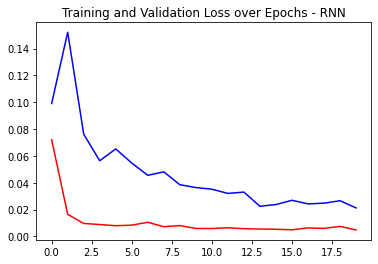

In [271]:
plotloss(train_loss, valid_loss, "Training and Validation Loss over Epochs - "+'RNN')

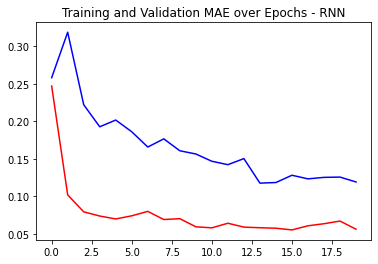

In [272]:
plotloss(train_mae, valid_mae, "Training and Validation MAE over Epochs - "+'RNN')

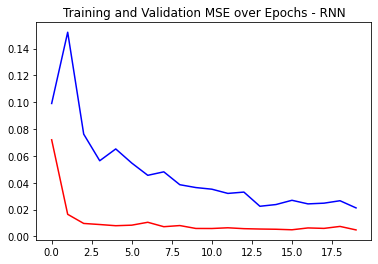

In [273]:
plotloss(train_mse, valid_mse, "Training and Validation MSE over Epochs - "+'RNN')

# Predictions and Trading Accuracy
Below the model predictions are graphed against the targets provided by the test data. The different winrates (daily, 3 days, 5 days, weekly) are then calculated to discern the quality of these predictions and allow for better comparison of the usefulness of the different models in actual trading.

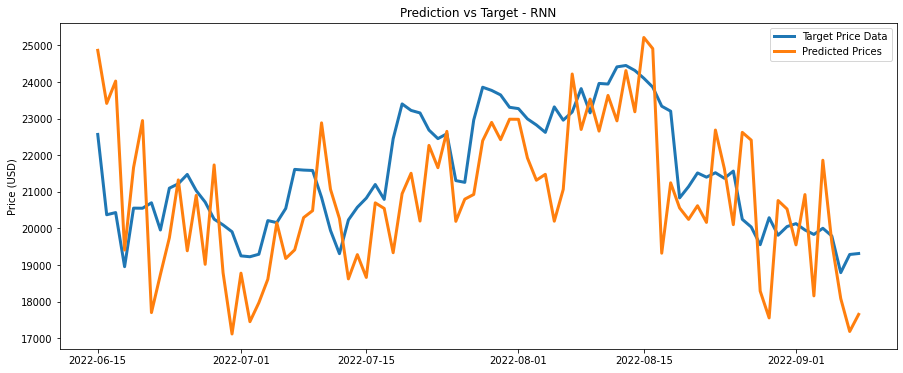

In [274]:
targind=targets.index
forecast = forecasts['rnn']
forecast = test[targ_column].values[:-length_of_seq] * (forecast + 1)
figure, ax = plt.subplots(1, figsize=(15, 6))
plot=ax.plot
ax.set_title('Prediction vs Target - '+'RNN')
plot(targets, label='Target Price Data', lw=3)
plot((pd.Series(index=targind, data=forecast)), label='Predicted Prices', lw=3)
ax.set_ylabel('Price (USD)')
ax.legend()

In [275]:
wins, winrate = calcwinrates(1, targets, forecast)
print("Daily Winrate")
print("Correct guesses: ",wins)
print("Winrate: ",winrate)

Daily Winrate
Correct guesses:  46
Winrate:  0.535


In [276]:
wins, winrate = calcwinrates(3, targets, forecast)
print("Tri-Daily Winrate")
print("Correct guesses: ",wins)
print("Winrate: ",winrate)

Tri-Daily Winrate
Correct guesses:  50
Winrate:  0.581


In [277]:
wins, winrate = calcwinrates(5, targets, forecast)
print("5-Day Winrate")
print("Correct guesses: ",wins)
print("Winrate: ",winrate)

5-Day Winrate
Correct guesses:  57
Winrate:  0.663


In [278]:
wins, winrate = calcwinrates(7, targets, forecast)
print("Weekly Winrate")
print("Correct guesses: ",wins)
print("Winrate: ",winrate)

Weekly Winrate
Correct guesses:  60
Winrate:  0.698


In [279]:
def displayResults(model):
  print(model.capitalize()+"\n")
  print("Overall MAE: ",mean_absolute_error(forecasts[model], y_test))
  print("Overall MSE: ",mean_squared_error(forecasts[model], y_test))
  print("Overall MAPE: ",mean_absolute_percentage_error(forecasts[model], y_test),"\n")

  hist = histories[model].history
  train_loss = hist['loss']
  valid_loss = hist['val_loss']
  train_mae = hist['MAE']
  valid_mae = hist['val_MAE']
  train_mse = hist['MSE']
  valid_mse = hist['val_MSE']

  plotloss(train_loss, valid_loss, "Training and Validation Loss over Epochs - "+model.capitalize())
  plotloss(train_mae, valid_mae, "Training and Validation MAE over Epochs - "+model.capitalize())
  plotloss(train_mse, valid_mse, "Training and Validation MSE over Epochs - "+model.capitalize())

  targind=targets.index
  forecast = forecasts[model]
  forecast = test[targ_column].values[:-length_of_seq] * (forecast + 1)
  figure, ax = plt.subplots(1, figsize=(15, 6))
  plot=ax.plot
  ax.set_title('Prediction vs Target - '+model.capitalize())
  plot(targets, label='Target Price Data', lw=3)
  plot((pd.Series(index=targind, data=forecast)), label='Predicted Prices', lw=3)
  ax.set_ylabel('Price (USD)')
  ax.legend()

  wins, winrate = calcwinrates(1, targets, forecast)
  print("Daily Winrate")
  print("Correct guesses: ",wins)
  print("Winrate: ",winrate)
  print("\n")

  wins, winrate = calcwinrates(3, targets, forecast)
  print("Tri-Daily Winrate")
  print("Correct guesses: ",wins)
  print("Winrate: ",winrate)
  print("\n")

  wins, winrate = calcwinrates(5, targets, forecast)
  print("5-Day Winrate")
  print("Correct guesses: ",wins)
  print("Winrate: ",winrate)
  print("\n")

  wins, winrate = calcwinrates(7, targets, forecast)
  print("Weekly Winrate")
  print("Correct guesses: ",wins)
  print("Winrate: ",winrate,"\n")

# LSTM Results

Lstm

Overall MAE:  0.04095346642321686
Overall MSE:  0.0033008596323425383
Overall MAPE:  1.0689335601908148 

Daily Winrate
Correct guesses:  48
Winrate:  0.558


Tri-Daily Winrate
Correct guesses:  50
Winrate:  0.581


5-Day Winrate
Correct guesses:  60
Winrate:  0.698


Weekly Winrate
Correct guesses:  63
Winrate:  0.733 



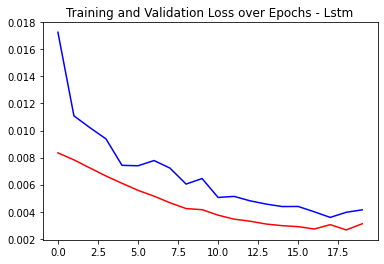

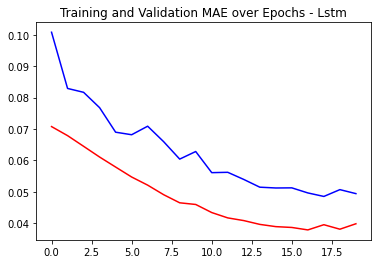

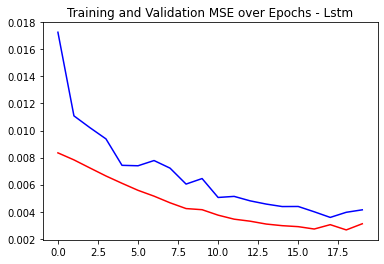

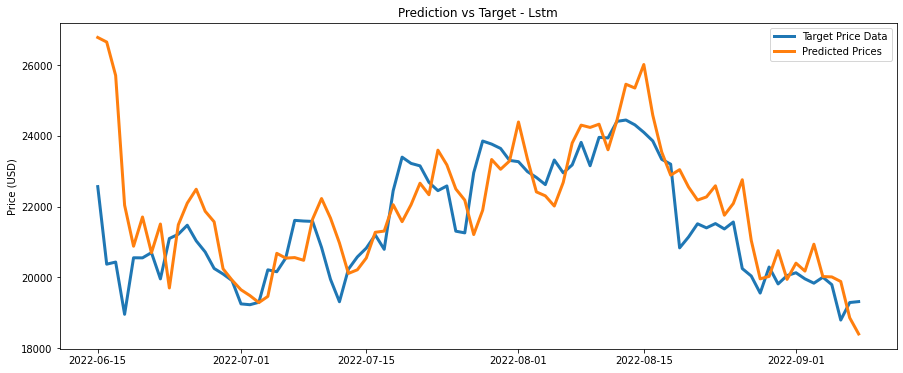

In [280]:
displayResults('lstm')

# CNN Results

Cnn

Overall MAE:  0.06149511653026362
Overall MSE:  0.006719630574061942
Overall MAPE:  8.175206674976648 

Daily Winrate
Correct guesses:  42
Winrate:  0.488


Tri-Daily Winrate
Correct guesses:  35
Winrate:  0.407


5-Day Winrate
Correct guesses:  32
Winrate:  0.372


Weekly Winrate
Correct guesses:  35
Winrate:  0.407 



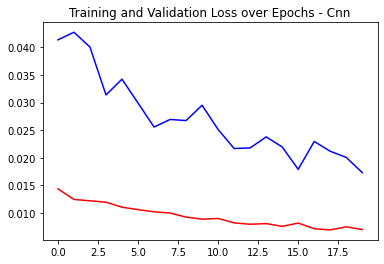

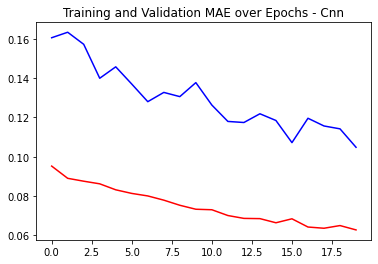

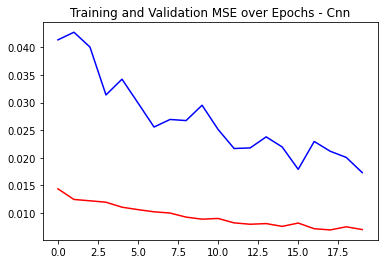

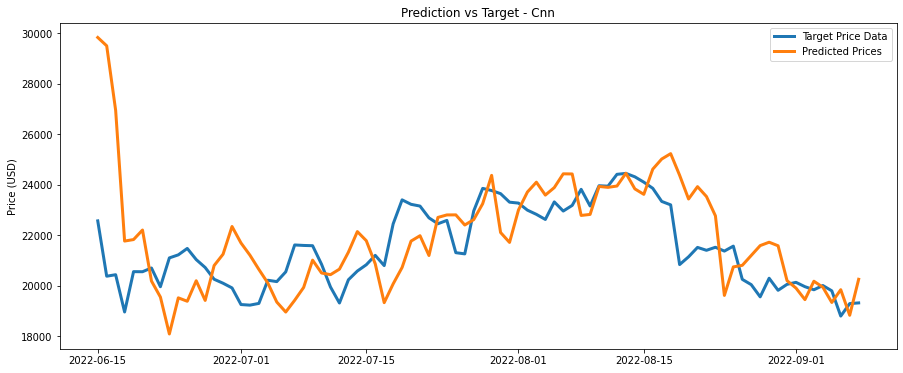

In [281]:
displayResults('cnn')

# GRU Results

Gru

Overall MAE:  0.03876232449504154
Overall MSE:  0.003047487092647369
Overall MAPE:  1.222384027755599 

Daily Winrate
Correct guesses:  48
Winrate:  0.558


Tri-Daily Winrate
Correct guesses:  53
Winrate:  0.616


5-Day Winrate
Correct guesses:  60
Winrate:  0.698


Weekly Winrate
Correct guesses:  60
Winrate:  0.698 



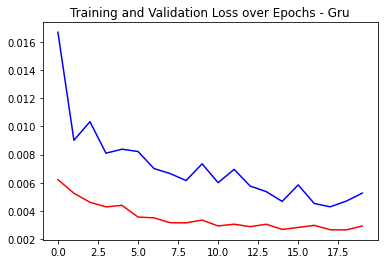

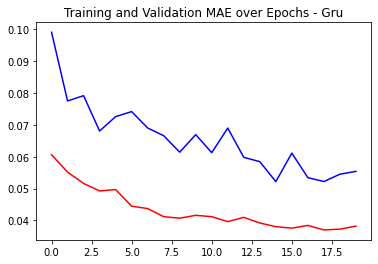

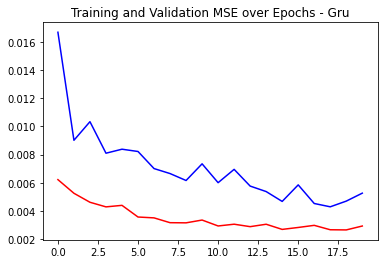

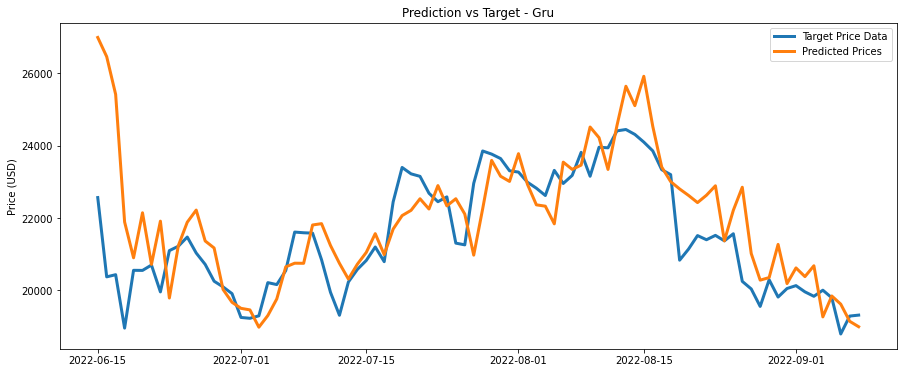

In [282]:
displayResults('gru')

# CNN-RNN Results

Cnnrnn

Overall MAE:  0.03882523591141129
Overall MSE:  0.002880272535654522
Overall MAPE:  1.2987394695757435 

Daily Winrate
Correct guesses:  47
Winrate:  0.547


Tri-Daily Winrate
Correct guesses:  51
Winrate:  0.593


5-Day Winrate
Correct guesses:  56
Winrate:  0.651


Weekly Winrate
Correct guesses:  64
Winrate:  0.744 



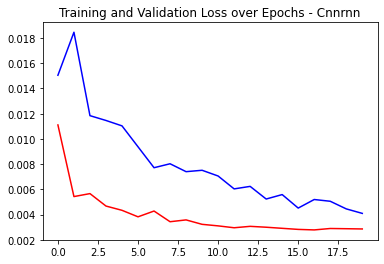

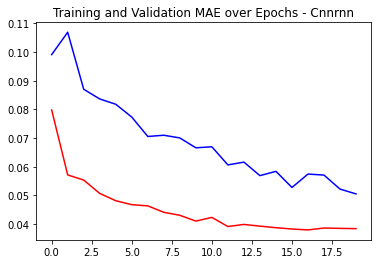

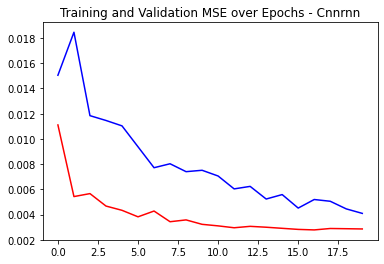

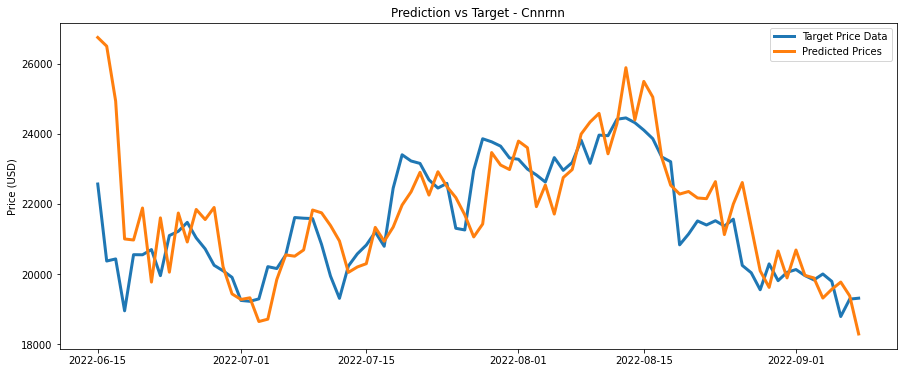

In [283]:
displayResults('cnnrnn')

# CNN-LSTM Results

Cnnlstm

Overall MAE:  0.03653267033591326
Overall MSE:  0.002551073266145827
Overall MAPE:  2.5086345820795057 

Daily Winrate
Correct guesses:  50
Winrate:  0.581


Tri-Daily Winrate
Correct guesses:  52
Winrate:  0.605


5-Day Winrate
Correct guesses:  60
Winrate:  0.698


Weekly Winrate
Correct guesses:  65
Winrate:  0.756 



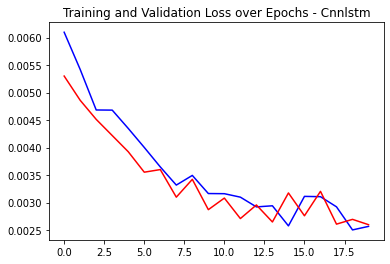

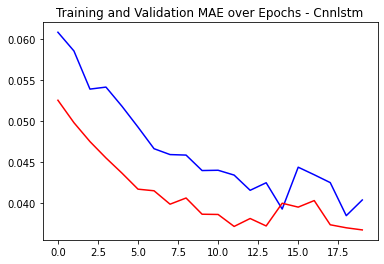

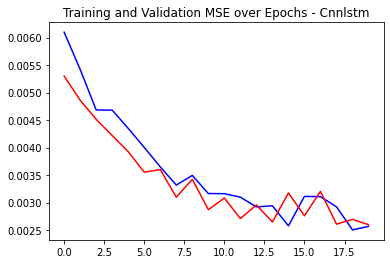

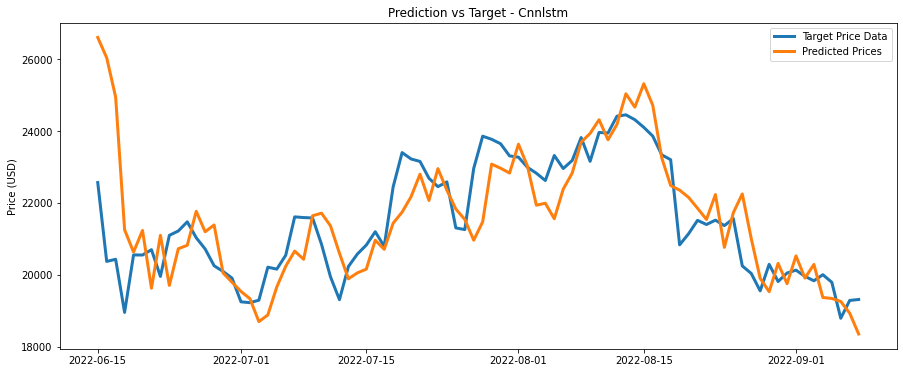

In [284]:
displayResults('cnnlstm')

# Deep RNN Results

Rnn2

Overall MAE:  0.03578773864494214
Overall MSE:  0.002479503082677201
Overall MAPE:  1.9535241147961215 

Daily Winrate
Correct guesses:  46
Winrate:  0.535


Tri-Daily Winrate
Correct guesses:  59
Winrate:  0.686


5-Day Winrate
Correct guesses:  65
Winrate:  0.756


Weekly Winrate
Correct guesses:  58
Winrate:  0.674 



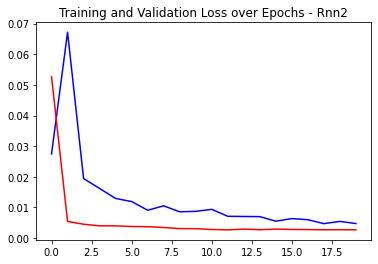

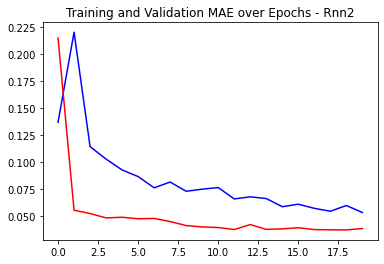

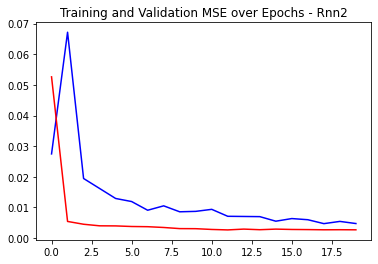

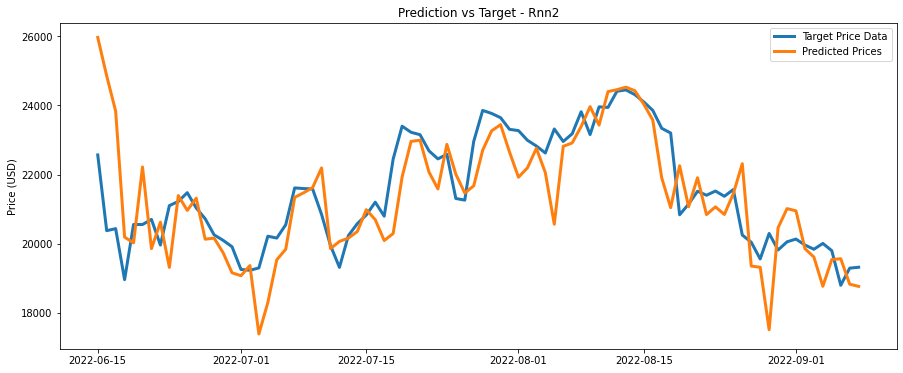

In [285]:
displayResults('rnn2')

# Deep LSTM Results

Lstm2

Overall MAE:  0.04095346642321686
Overall MSE:  0.0033008596323425383
Overall MAPE:  1.0689335601908148 

Daily Winrate
Correct guesses:  48
Winrate:  0.558


Tri-Daily Winrate
Correct guesses:  50
Winrate:  0.581


5-Day Winrate
Correct guesses:  60
Winrate:  0.698


Weekly Winrate
Correct guesses:  63
Winrate:  0.733 



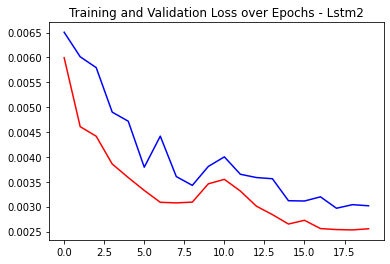

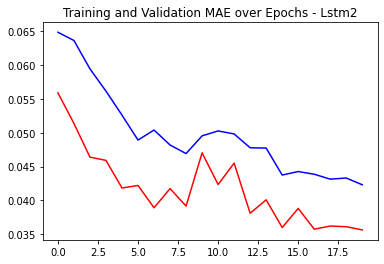

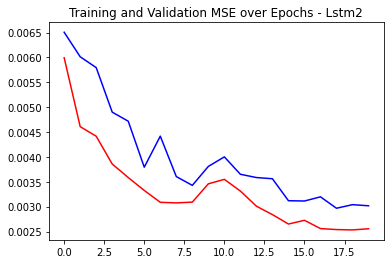

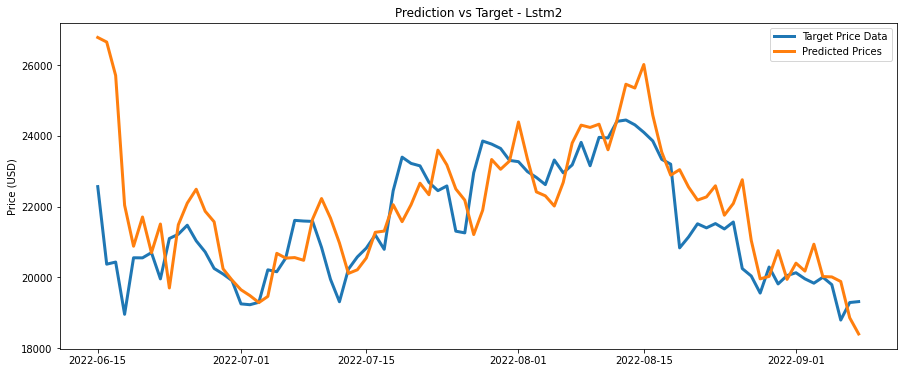

In [286]:
displayResults('lstm2')

# Deep CNN Results

Cnn2

Overall MAE:  0.06149511653026362
Overall MSE:  0.006719630574061942
Overall MAPE:  8.175206674976648 

Daily Winrate
Correct guesses:  42
Winrate:  0.488


Tri-Daily Winrate
Correct guesses:  35
Winrate:  0.407


5-Day Winrate
Correct guesses:  32
Winrate:  0.372


Weekly Winrate
Correct guesses:  35
Winrate:  0.407 



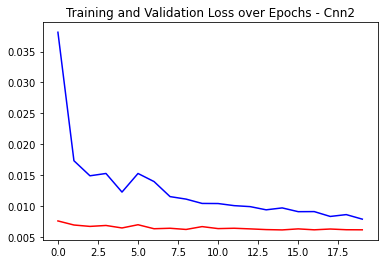

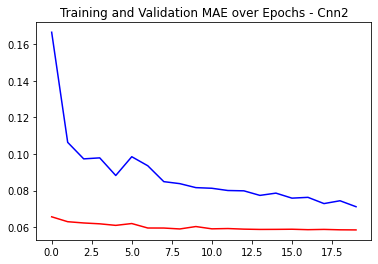

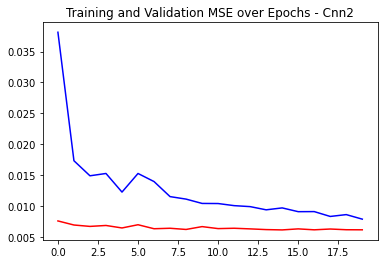

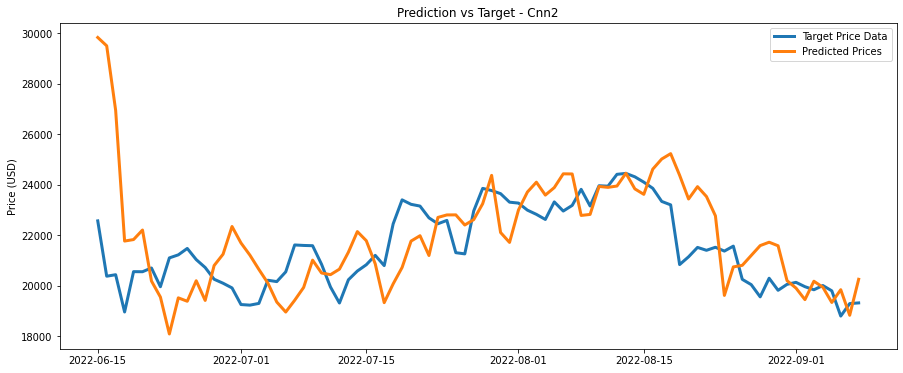

In [287]:
displayResults('cnn2')

# Deep GRU Results

Gru2

Overall MAE:  0.03876232449504154
Overall MSE:  0.003047487092647369
Overall MAPE:  1.222384027755599 

Daily Winrate
Correct guesses:  48
Winrate:  0.558


Tri-Daily Winrate
Correct guesses:  53
Winrate:  0.616


5-Day Winrate
Correct guesses:  60
Winrate:  0.698


Weekly Winrate
Correct guesses:  60
Winrate:  0.698 



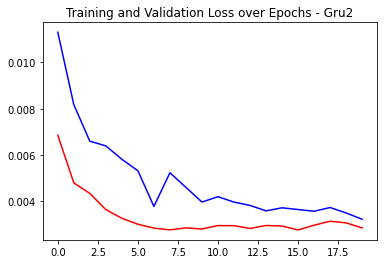

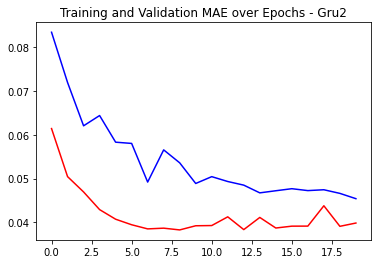

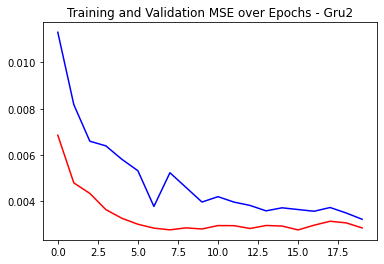

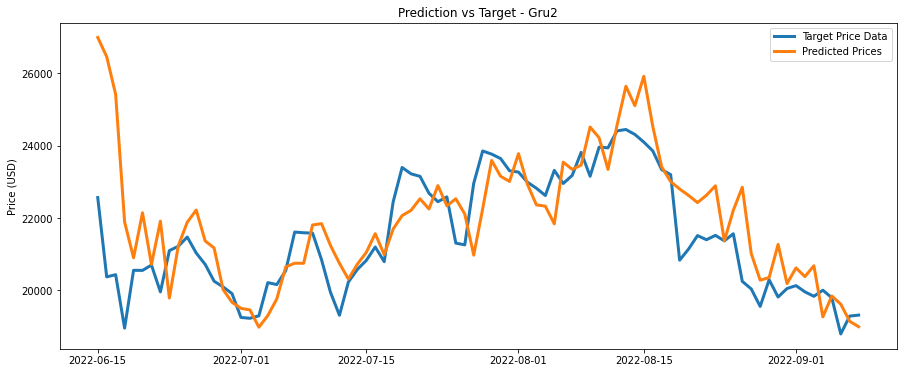

In [288]:
displayResults('gru2')

# Deep CNN-RNN Results

Cnnrnn2

Overall MAE:  0.03882523591141129
Overall MSE:  0.002880272535654522
Overall MAPE:  1.2987394695757435 

Daily Winrate
Correct guesses:  47
Winrate:  0.547


Tri-Daily Winrate
Correct guesses:  51
Winrate:  0.593


5-Day Winrate
Correct guesses:  56
Winrate:  0.651


Weekly Winrate
Correct guesses:  64
Winrate:  0.744 



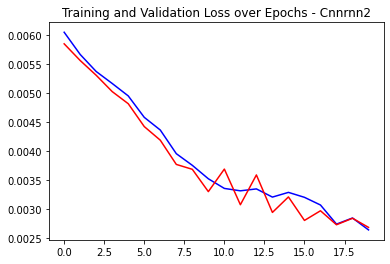

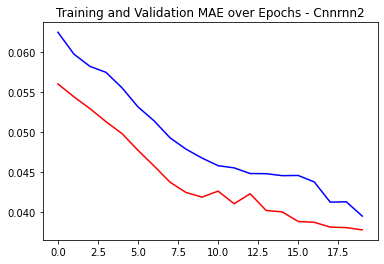

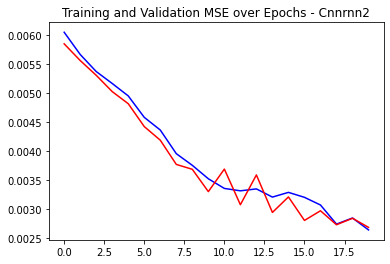

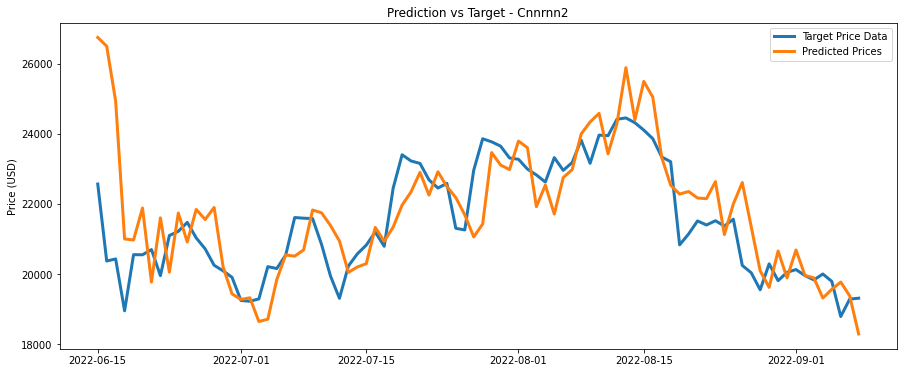

In [289]:
displayResults('cnnrnn2')

# Deep CNN-LSTM Results

Cnnlstm2

Overall MAE:  0.03653267033591326
Overall MSE:  0.002551073266145827
Overall MAPE:  2.5086345820795057 

Daily Winrate
Correct guesses:  50
Winrate:  0.581


Tri-Daily Winrate
Correct guesses:  52
Winrate:  0.605


5-Day Winrate
Correct guesses:  60
Winrate:  0.698


Weekly Winrate
Correct guesses:  65
Winrate:  0.756 



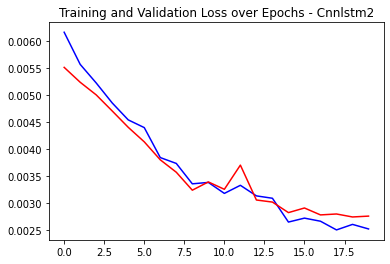

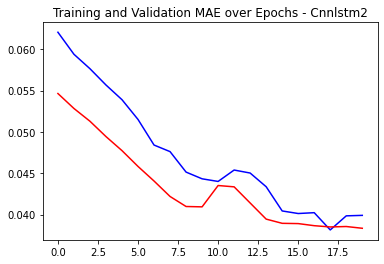

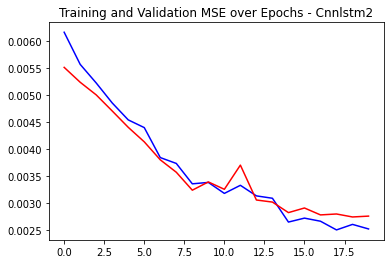

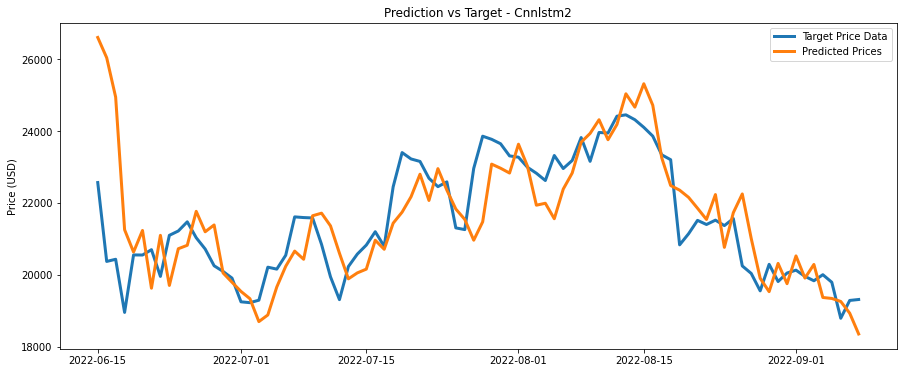

In [290]:
displayResults('cnnlstm2')

# Display Grouped Data for Easy Comparison

In [291]:
def displayMetrics(forecasts, histories):
  for x in forecasts:
    print(str(x).capitalize())
    results = [round(mean_absolute_error(forecasts[x], y_test), 2),
               round(mean_squared_error(forecasts[x], y_test), 2),
               round(mean_absolute_percentage_error(forecasts[x], y_test), 2)]

    wins, winrate = calcwinrates(1, targets, forecasts[x])
    results.append(winrate)

    wins, winrate = calcwinrates(3, targets, forecasts[x])
    results.append(winrate)

    wins, winrate = calcwinrates(5, targets, forecasts[x])
    results.append(winrate)

    wins, winrate = calcwinrates(7, targets, forecasts[x])
    results.append(winrate)

    print(results,"\n")

In [292]:
def displayGraphs(forecasts, histories):
  for x in forecasts:
    targind=targets.index
    forecast = forecasts[x]
    forecast = test[targ_column].values[:-length_of_seq] * (forecast + 1)
    figure, ax = plt.subplots(1, figsize=(15, 6))
    plot=ax.plot
    ax.set_title('Prediction vs Target - '+str(x).capitalize())
    plot(targets, label='Target Price Data', lw=3)
    plot((pd.Series(index=targind, data=forecast)), label='Predicted Prices', lw=3)
    ax.set_ylabel('Price (USD)')
    ax.legend()

In [293]:
displayMetrics(forecasts, histories)

Rnn
[0.06, 0.01, 2.51, 0.523, 0.651, 0.744, 0.698] 

Lstm
[0.04, 0.0, 1.07, 0.512, 0.686, 0.791, 0.698] 

Cnn
[0.06, 0.01, 8.18, 0.547, 0.57, 0.558, 0.465] 

Gru
[0.04, 0.0, 1.22, 0.547, 0.698, 0.756, 0.698] 

Cnnrnn
[0.04, 0.0, 1.3, 0.535, 0.686, 0.767, 0.721] 

Cnnlstm
[0.04, 0.0, 2.51, 0.523, 0.698, 0.791, 0.721] 

Rnn2
[0.04, 0.0, 1.95, 0.581, 0.744, 0.744, 0.674] 

Lstm2
[0.04, 0.0, 1.07, 0.512, 0.686, 0.791, 0.698] 

Cnn2
[0.06, 0.01, 8.18, 0.547, 0.57, 0.558, 0.465] 

Gru2
[0.04, 0.0, 1.22, 0.547, 0.698, 0.756, 0.698] 

Cnnrnn2
[0.04, 0.0, 1.3, 0.535, 0.686, 0.767, 0.721] 

Cnnlstm2
[0.04, 0.0, 2.51, 0.523, 0.698, 0.791, 0.721] 



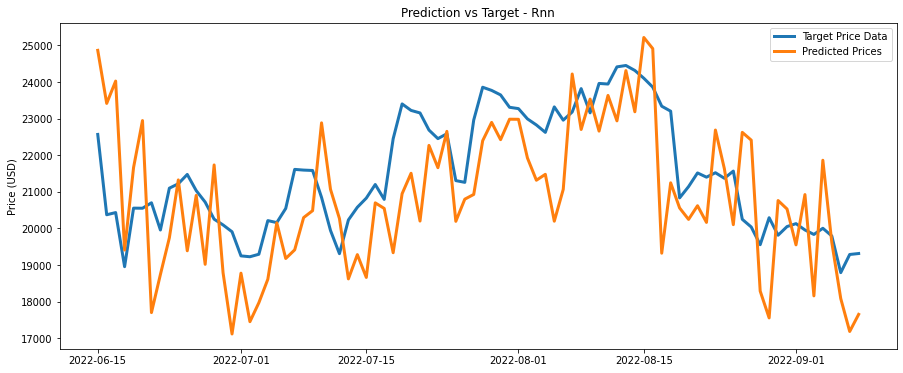

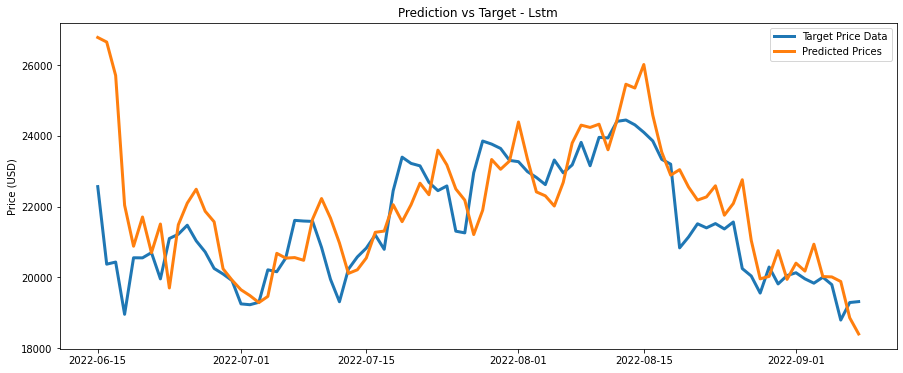

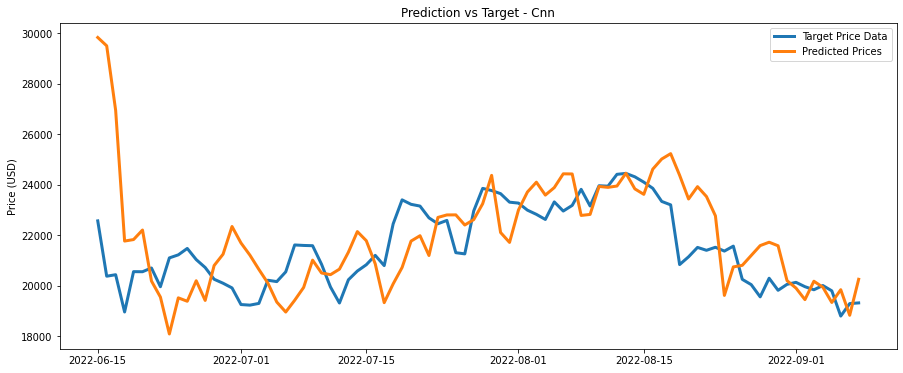

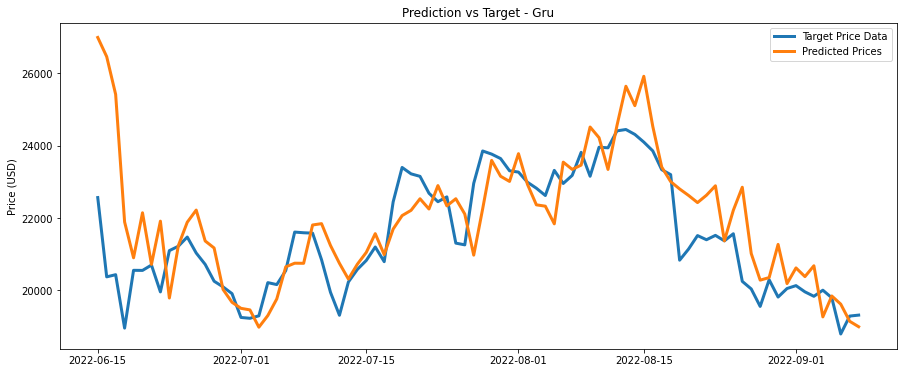

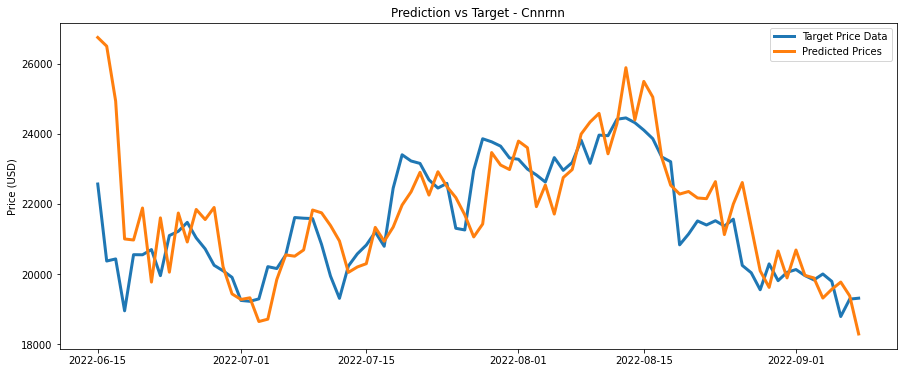

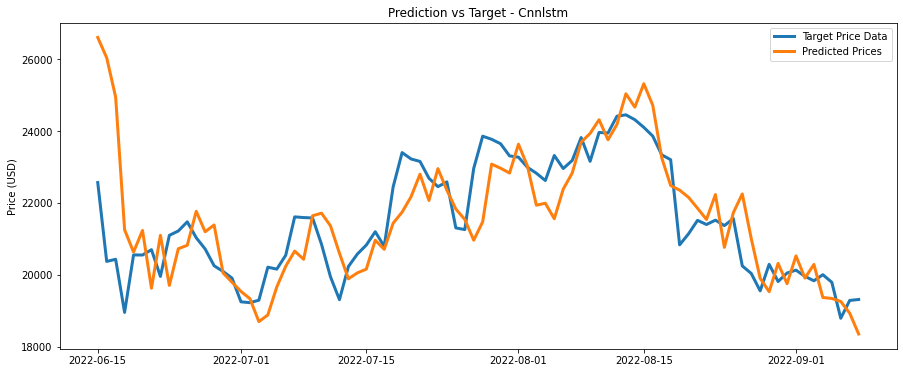

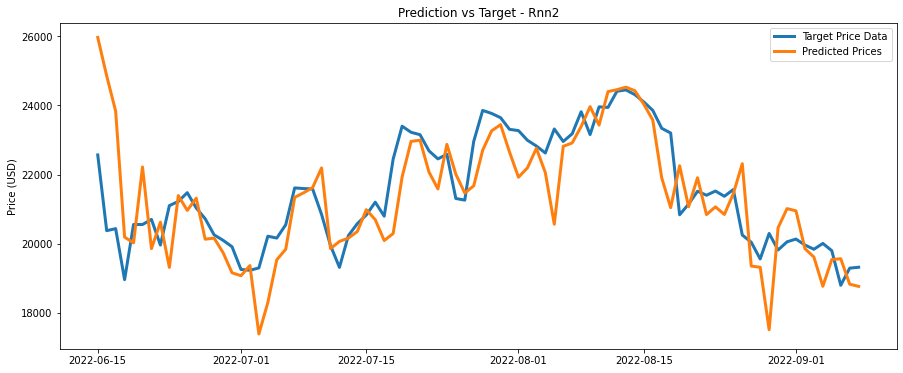

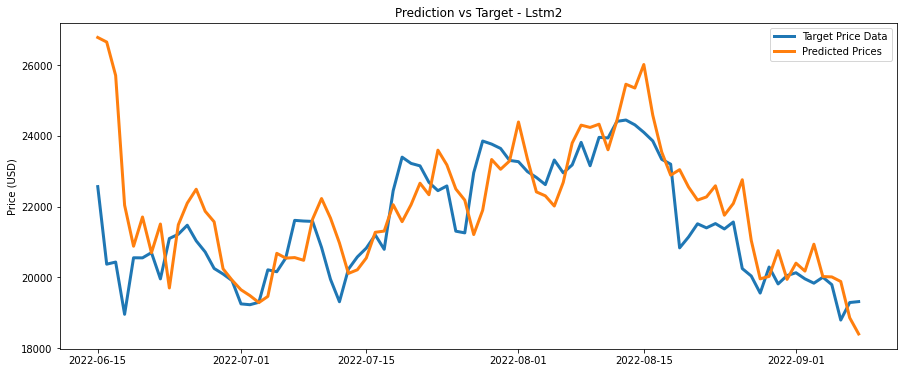

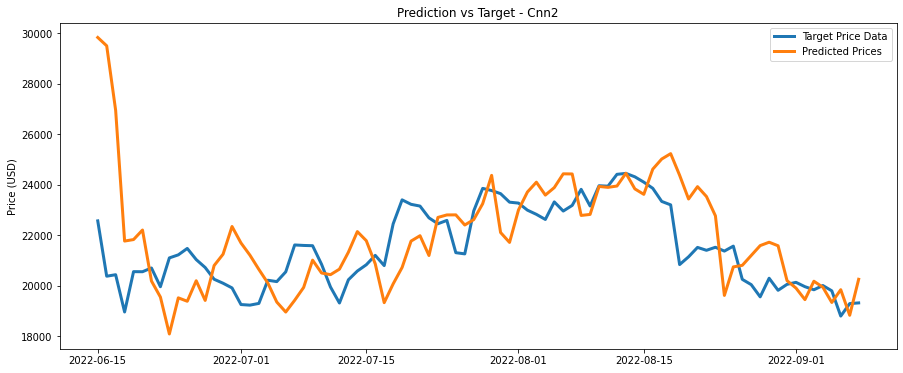

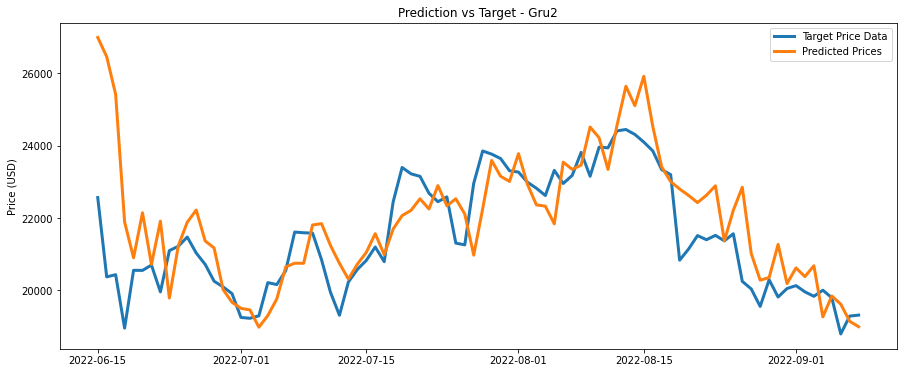

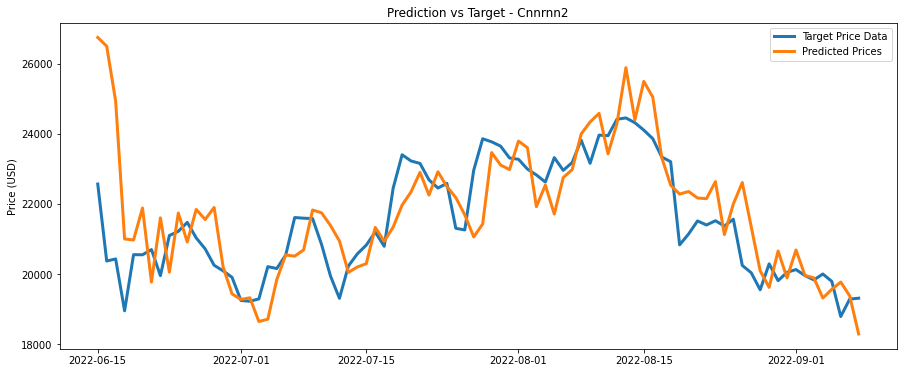

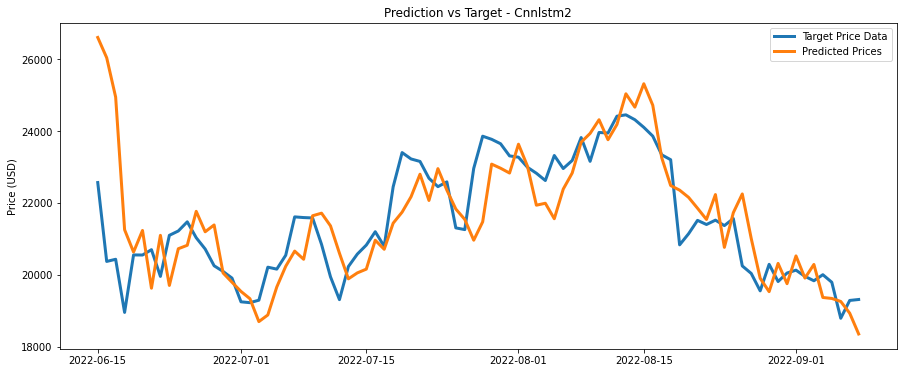

In [294]:
displayGraphs(forecasts, histories)

In [295]:
def showBest(forecasts):
  dailywinrates={}
  weeklywinrates={}
  for x in forecasts:
    wins, winrate = calcwinrates(1, targets, forecasts[x])
    dailywinrates[x] = winrate
    wins, winrate = calcwinrates(7, targets, forecasts[x])
    weeklywinrates[x] = winrate
  return sorted(dailywinrates, key=dailywinrates.get, reverse=True)[:3], sorted(weeklywinrates, key=weeklywinrates.get, reverse=True)[:3]

print(showBest(forecasts))

(['rnn2', 'cnn', 'gru'], ['cnnrnn', 'cnnlstm', 'cnnrnn2'])
